<a href="https://colab.research.google.com/github/SaumilShah-7/Toxic-Comment-Classification-Challenge-Kaggle/blob/master/Toxic_Comment_Classification_(GRU%2BFastText).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing import text, sequence

2.2.0


In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 97.7MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 205MB/s]
 73% 17.0M/23.4M [00:00<00:00, 26.0MB/s]
100% 23.4M/23.4M [00:00<00:00, 59.2MB/s]
 34% 9.00M/26.3M [00:01<00:01, 11.0MB/s]
100% 26.3M/26.3M [00:01<00:00, 23.7MB/s]


In [0]:
!unzip -q -o train.csv.zip
!unzip -q -o test.csv.zip
!unzip -q -o test_labels.csv.zip
!rm train.csv.zip
!rm test.csv.zip
!rm test_labels.csv.zip

In [5]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(159571, 8)
(153164, 2)


In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Empty comments in train dataset: 0


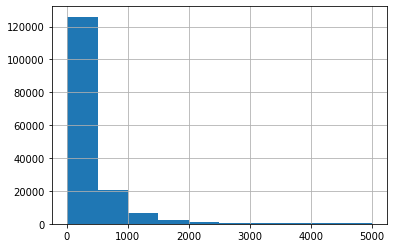

In [7]:
train.comment_text.str.len().hist()
print("Empty comments in train dataset:", len(train[train.comment_text.str.len()==0]))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


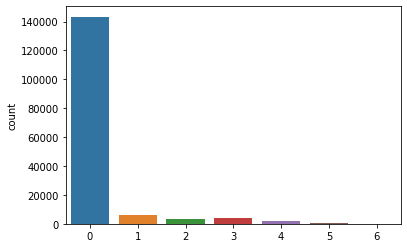

In [8]:
import seaborn as sns
sns.countplot(train[list(train.columns)[2:]].sum(axis=1))

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
none             143346
dtype: int64


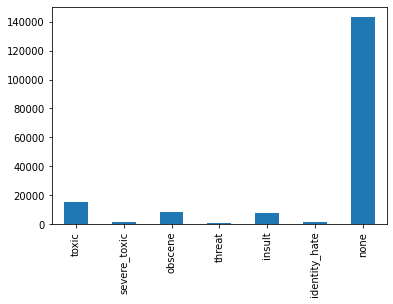

In [9]:
train['none'] = 1 - train[list(train.columns)[2:]].max(axis=1)

train[list(train.columns)[2:]].sum().plot(kind='bar')
print(train[list(train.columns)[2:]].sum())

In [0]:
max_features = 30000

In [11]:
t = text.Tokenizer(num_words=max_features)
t.fit_on_texts(train['comment_text'])

print(len(t.word_index))

210337


In [12]:
X_train = t.texts_to_sequences(train['comment_text'])
X_test = t.texts_to_sequences(test['comment_text'])

print(X_train[0])

[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


In [13]:
maxlen = 100
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

y_train = train[list(train.columns)[2:-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape)

(159571, 100) (159571, 6)
(153164, 100)


In [14]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2020-05-16 05:20:47--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  10.5MB/s    in 2m 20s  

2020-05-16 05:23:09 (10.4 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [0]:
!unzip -q -o crawl-300d-2M.vec.zip
!rm crawl-300d-2M.vec.zip

In [0]:
def get_coefs(word,*arr):
  return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open('crawl-300d-2M.vec'))

In [0]:
embed_size = 300

word_index = t.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= nb_words: 
      continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector

In [0]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

def get_model():
  inp = Input(shape=(maxlen, ))
  x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
  x = SpatialDropout1D(0.2)(x)
  x = Bidirectional(GRU(80, return_sequences=True))(x)
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  outp = Dense(6, activation="sigmoid")(conc)
  
  model = Model(inputs=inp, outputs=outp)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [0]:
model = get_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 160)     183360      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

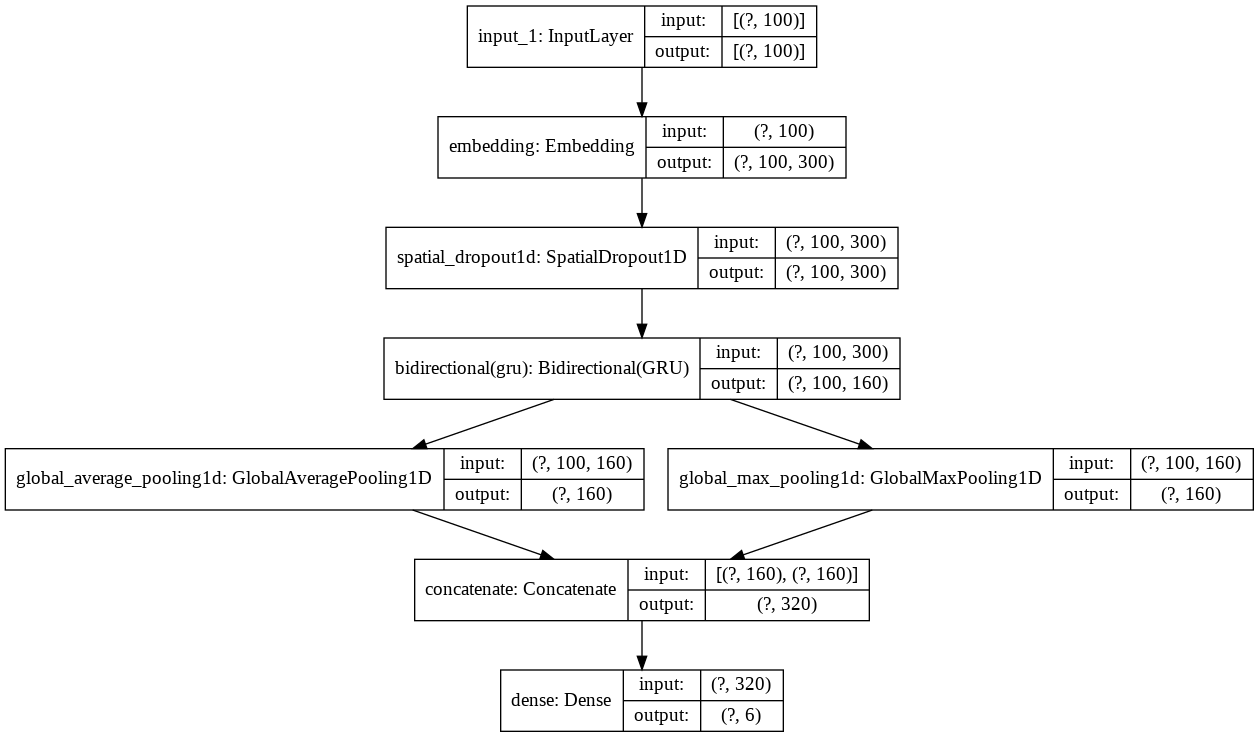

In [20]:
print(model.summary())
plot_model(model, show_shapes=True)

In [0]:
from sklearn.model_selection import train_test_split

x_tra, x_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)

In [0]:
from tensorflow.keras.callbacks import Callback,ModelCheckpoint
from sklearn.metrics import roc_auc_score

class RocCallback(Callback):
  def __init__(self, validation_data):
    self.x_val = validation_data[0]
    self.y_val = validation_data[1]

  def on_epoch_end(self, epoch, logs={}):
    y_pred_val = self.model.predict(self.x_val)
    roc_val = roc_auc_score(self.y_val, y_pred_val)
    print(' - Roc-auc_val: %.6f' % roc_val)
    # self.model.save_weights('model_%d_%.7f.h5' % (epoch+1, roc_val))
    return

roc = RocCallback(validation_data=(x_val, y_val))

In [23]:
batch_size = 32
epochs = 2

hist = model.fit(x_tra, y_tra, batch_size=batch_size, callbacks=[roc], epochs=epochs, validation_data=(x_val, y_val), verbose=1)

Epoch 1/2
4738/4738 [==============================] - 1305s 275ms/step - loss: 0.0498 - accuracy: 0.9366 - val_loss: 0.0460 - val_accuracy: 0.8042
Epoch 2/2
4738/4738 [==============================] - 1287s 272ms/step - loss: 0.0380 - accuracy: 0.8912 - val_loss: 0.0450 - val_accuracy: 0.9511


In [0]:
y_pred = model.predict(x_test, batch_size=1024)

In [0]:
submid = pd.DataFrame({'id': test['id']})
submission = pd.concat([submid, pd.DataFrame(y_pred, columns = list(train.columns)[2:-1])], axis=1)
submission.to_csv('submission.csv', index=False)